In [1]:
from mlxtend.plotting import scatterplotmatrix

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

train = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/sample_submission.csv')
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


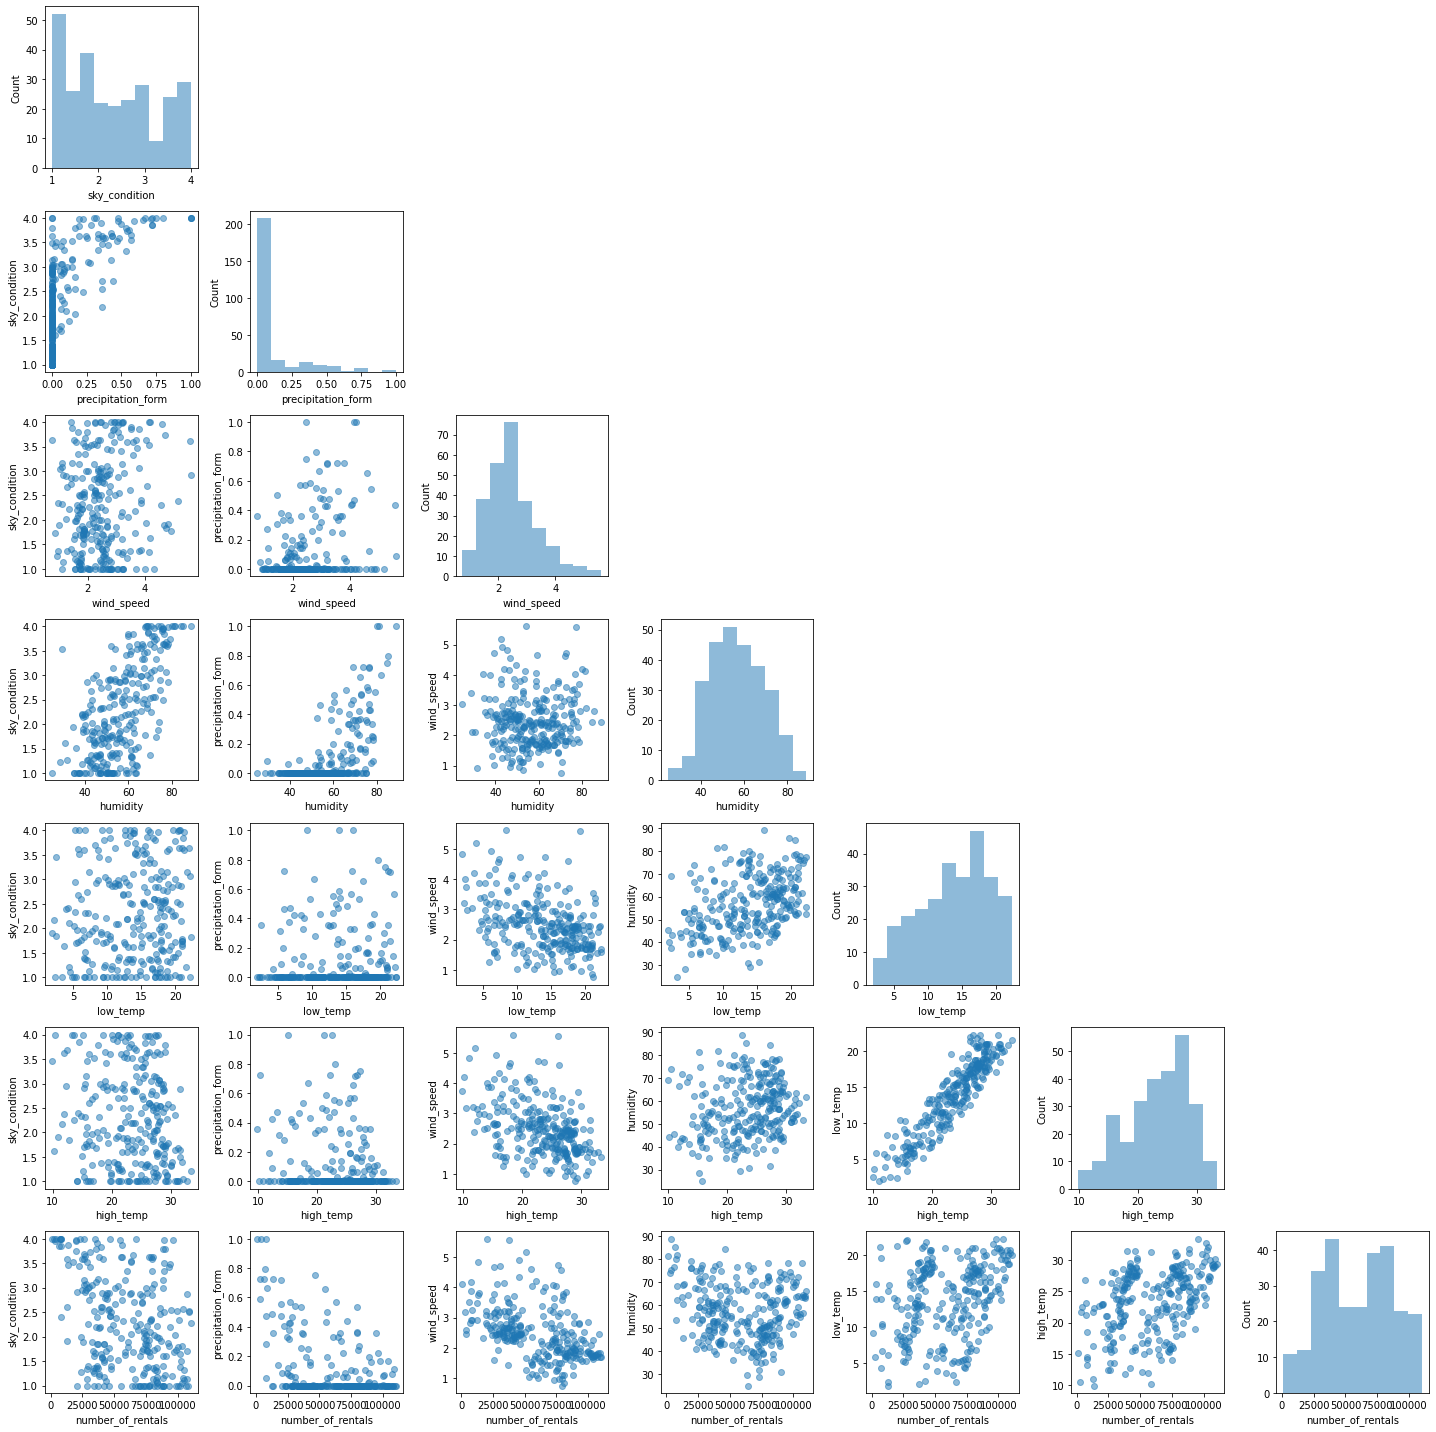

In [23]:
cols = ['sky_condition',
       'precipitation_form',
       'wind_speed',
       'humidity',
       'low_temp',
       'high_temp',
       'number_of_rentals']

scatterplotmatrix(train[cols].values, figsize=(20,20),names=cols,alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# weekend 토요일 일요일이 아니고 날씨도 좋았지만 대여량이 낮은날.
# discomfort index
# sensible temperature


In [25]:
bicycle = train

In [26]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(bicycle.columns):
        missing_values = sum(bicycle[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(bicycle.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(bicycle)

결측치가 존재하지 않습니다


In [27]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point)-2017)
        month.append(int(month_point)-3)
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(bicycle)

bicycle['year'] = year
bicycle['month'] = month
bicycle['day'] = day

bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,1,1,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,1,1,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,1,1,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,1,1,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,1,1,5


In [28]:
# 요일 정보 추가

X = bicycle.drop(['date_time', 'number_of_rentals'], axis=1)
y = bicycle.number_of_rentals
X_human = X.copy()
from sklearn.preprocessing import LabelEncoder

week_day = pd.to_datetime(bicycle['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
X_human['week_day'] = le.transform(week_day)
X_human.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1,3
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2,1
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3,5
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4,6
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,5,4


In [29]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_human['temp_diff_info'] = X_human['high_temp'] - X_human['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_human['sweat_info'] = X_human['high_temp'] * X_human['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_human['cold_info'] = X_human['low_temp'] * X_human['wind_speed'] 

X_human.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day,temp_diff_info,sweat_info,cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1,3,8.400,1575.000000,38.430000
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2,1,6.188,1326.827000,41.997736
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3,5,5.004,1146.846764,27.739280
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4,6,4.056,888.628432,26.083056
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,5,4,4.546,768.903064,18.717750


In [30]:
X_computer = X.copy()

col_list = X_computer.columns

# 이중 for문을 사용하여 feature 자기 자신의 제곱과 두 feature간의 곱이라는 새로운 feature를 추가합니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_computer[f'{col_list[i]}*{col_list[j]}'] = X_computer[col_list[i]] * X_computer[col_list[j]]

X_computer

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,wind_direction*wind_direction,wind_direction*sky_condition,wind_direction*precipitation_form,wind_direction*wind_speed,wind_direction*humidity,wind_direction*low_temp,wind_direction*high_temp,wind_direction*Precipitation_Probability,wind_direction*year,wind_direction*month,wind_direction*day,sky_condition*sky_condition,sky_condition*precipitation_form,sky_condition*wind_speed,sky_condition*humidity,sky_condition*low_temp,sky_condition*high_temp,sky_condition*Precipitation_Probability,sky_condition*year,sky_condition*month,sky_condition*day,precipitation_form*precipitation_form,precipitation_form*wind_speed,precipitation_form*humidity,precipitation_form*low_temp,precipitation_form*high_temp,precipitation_form*Precipitation_Probability,precipitation_form*year,precipitation_form*month,precipitation_form*day,wind_speed*wind_speed,wind_speed*humidity,wind_speed*low_temp,wind_speed*high_temp,wind_speed*Precipitation_Probability,wind_speed*year,wind_speed*month,wind_speed*day,humidity*humidity,humidity*low_temp,humidity*high_temp,humidity*Precipitation_Probability,humidity*year,humidity*month,humidity*day,low_temp*low_temp,low_temp*high_temp,low_temp*Precipitation_Probability,low_temp*year,low_temp*month,low_temp*day,high_temp*high_temp,high_temp*Precipitation_Probability,high_temp*year,high_temp*month,high_temp*day,Precipitation_Probability*Precipitation_Probability,Precipitation_Probability*year,Precipitation_Probability*month,Precipitation_Probability*day,year*year,year*month,year*day,month*month,month*day,day*day
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1,43056.250000,830.000000,0.000000,632.875000,15562.500000,2614.500000,4357.500000,6225.000000,207.500,207.500,207.500,16.000000,0.000000,12.200000,300.000000,50.400000,84.000000,120.000000,4.000,4.000,4.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,9.302500,228.750000,38.430000,64.050000,91.500000,3.050,3.050,3.050,5625.000000,945.000000,1575.000000,2250.000000,75.000,75.000,75.000,158.760000,264.600000,378.000000,12.600,12.600,12.600,441.000000,630.000000,21.000,21.000,21.000,900.000000,30.000,30.000,30.000,1,1,1,1,1,1
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2,43395.972489,614.535150,0.000000,682.863126,14547.401061,2668.957404,3958.023000,4062.181500,208.317,208.317,416.634,8.702500,0.000000,9.670100,206.007350,37.795400,56.050000,57.525000,2.950,2.950,5.900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,10.745284,228.912574,41.997736,62.282000,63.921000,3.278,3.278,6.556,4876.647889,894.700396,1326.827000,1361.743500,69.833,69.833,139.666,164.147344,243.428000,249.834000,12.812,12.812,25.624,361.000000,370.500000,19.000,19.000,38.000,380.250000,19.500,19.500,39.000,1,1,2,1,2,4
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3,45589.082256,621.545076,0.000000,574.358040,15987.864564,2201.776992,3270.211056,4080.931308,213.516,213.516,640.548,8.473921,0.000000,7.830590,217.972769,30.018232,44.584876,55.637943,2.911,2.911,8.733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,7.236100,201.424510,27.739280,41.200040,51.413970,2.690,2.690,8.070,5606.864641,772.152248,1146.846764,1431.162327,74.879,74.879,224.637,106.337344,157.938592,197.093256,10.312,10.312,30.936,234.579856,292.734708,15.316,15.316,45.948,365.306769,19.113,19.113,57.339,1,1,3,1,3,9
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4,20688.794896,531.042512,61.130300,451.357368,10334.472764,1195.564832,1778.963648,6255.859148,143.836,143.836,575.344,13.630864,1.569100,11.585496,265.266508,30.687904,45.662656,160.576156,3.692,3.692,14.768,0.180625,1.333650,30.535825,3.532600,5.256400,18.484525,0.425,0.425,1.700,9.847044,225.462162,26.083056,38.810784,136.481034,3.138,3.138,12.552,5162.278801,597.208888,888.628432,3124.928557,71.849,71.849,287.396,69.089

In [33]:
# 3

# 3번은 2번에 사람의 도메인 지식을 추가한 형태입니다.
X_combination = X.copy()

# 요일 정보 추가
week_day = pd.to_datetime(bicycle['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
X_combination['week_day'] = le.transform(week_day)

# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_combination['temp_diff_info'] = X_combination['high_temp'] - X_combination['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_combination['sweat_info'] = X_combination['high_temp'] * X_combination['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_combination['cold_info'] = X_combination['low_temp'] * X_combination['wind_speed'] 

col_list = X_combination.columns

# 이중 for문을 사용하여 변수 자기 자신의 제곱과 두 변수간의 곱이라는 새로운 변수를 추가합니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_combination[f'{col_list[i]}*{col_list[j]}'] = X_combination[col_list[i]] * X_combination[col_list[j]]

X_combination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Columns: 135 entries, wind_direction to cold_info*cold_info
dtypes: float64(121), int64(14)
memory usage: 288.1 KB


In [34]:
# random forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)

forest.fit(X_combination,y)
y_hat = forest.predict(X_combination)

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

score = NMAE(y, y_hat)

print(f'모델 NMAE: {score}')

모델 NMAE: 0.0873809278749938


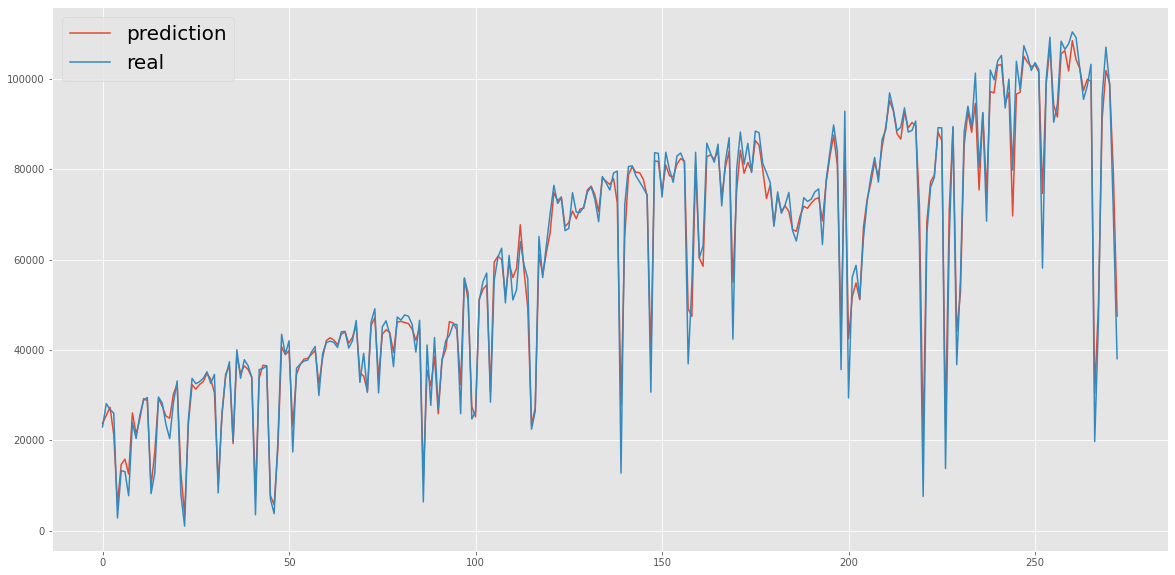

In [35]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [ ]:
check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리 후

#새로운 컬럼을 생성
test['year'] = year
test['month'] = month
test['day'] = day

test.head()

결측치가 존재하지 않습니다


,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5


In [ ]:
# # baseline
# # 문자열인 date_time 컬럼 drop
# test_X = test.drop('date_time','wind_direction','Precipitation_Probability' axis = 1)

# # train data로 학습시킨 모델에 test_X데이터를 넣고 예측
# test_yhat = model.predict(test_X)

# # submission dataFrame 완성
# sample_submission['number_of_rentals'] = test_yhat

# # 제출 파일 생성
# sample_submission.to_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/base_line.csv', index= False)

In [ ]:
# rf
# 문자열인 date_time 컬럼 drop
test_X = test.drop(['date_time','wind_direction','Precipitation_Probability'], axis = 1)

# train data로 학습시킨 모델에 test_X데이터를 넣고 예측
test_yhat = forest.predict(test_X)

# submission dataFrame 완성
sample_submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
sample_submission.to_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/rf.csv', index= False)

In [ ]:
# 1.다중회귀 앙상블
# 2.randomserch cv 적용
# 3.아래 계산해서 칼럼 추가
# weekend 토요일 일요일이 아니고 날씨도 좋았지만 대여량이 낮은날.
# discomfort index 불쾌지수
# sensible temperature 체감온도
# 4.wb,optuna 적용 가능 탐색
# 유튜브 데이터 홀릭



# 1. 정규화 표준화
# 2. 요일컬럼 추가
# 3. 불쾌지수
# 4. 체감온도
# 5. 논문탐색
# 6. 앙상블 구성
# 7. 옵튜나 적용
# 8. 일교차
# 9. 컬럼 중요도


# # 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
# X_combination['temp_diff_info'] = X_combination['high_temp'] - X_combination['low_temp']

# # 2. "덥고 습한 날씨"를 알기 위한 정보
# X_combination['sweat_info'] = X_combination['high_temp'] * X_combination['humidity'] 

# # 3. "춥고 바람부는 날씨"를 알기 위한 정보
# X_combination['cold_info'] = X_combination['low_temp'] * X_combination['wind_speed'] 